# 🔍 Fake News Detection with LIAR2 — A Multimodal NLP Approach

**Authors:** Sid Ahmed BOUAMAMA & Aya MESSAOUDI  
**Course:** Hands-on Natural Language Processing — Sorbonne Paris Nord, 2025-2026  
**Date:** February 2026

---

## Research Question

> *"Is text alone sufficient to detect fake news? Or do we need structured metadata about the speaker?"*

## Project Overview

This notebook presents a **complete NLP pipeline** for fake news detection on the **LIAR2 dataset** — a real-world fact-checking benchmark from PolitiFact. We progressively explore techniques from the NLP course and beyond:

```
PROGRESSION ROADMAP
═══════════════════════════════════════════════════════════════════════

Phase 1 — Classical NLP Baselines (Course Techniques)
├── TF-IDF + Logistic Regression            → Text representation basics
├── Word2Vec + Random Forest                 → Dense embeddings
├── Metadata-only models                     → Signal analysis
└── Text + Metadata concatenation            → Simple multimodal

Phase 2 — Transformer Approaches (Course + Extensions)
├── RoBERTa / DeBERTa Frozen + Head          → Feature extraction (course)
├── LoRA (Parameter-Efficient Fine-Tuning)   → Efficient adaptation (research)
└── Full Fine-Tuning                         → Maximum adaptation

Phase 3 — Fusion & Advanced Optimization (Research)
├── Late Fusion (Transformer + MLP)          → Multimodal architecture
├── Focal Loss + Label Smoothing             → Loss engineering
├── Progressive Unfreezing                   → Training stabilization
└── AutoGluon (AutoML benchmark)             → Upper bound comparison

KEY FINDING: Word2Vec+Metadata (2013) beats DeBERTa (2021) by +8 F1 pts!
             → Text alone is INSUFFICIENT. The signal is in the metadata.
             → Late Fusion corrects this by giving transformers access to metadata.
═══════════════════════════════════════════════════════════════════════
```

**References:**
1. Wang, W.Y. (2017). *"Liar, Liar Pants on Fire."* ACL 2017.
2. Xu & Kechadi (2024). *FDHN: Fuzzy Deep Hybrid Network.* IEEE Access. (SOTA = 0.712 F1)
3. Hu et al. (2021). *LoRA: Low-Rank Adaptation.* ICLR 2022.
4. Lin et al. (2017). *Focal Loss for Dense Object Detection.* ICCV 2017.
5. Szegedy et al. (2016). *Rethinking the Inception Architecture.* CVPR 2016.
6. Howard & Ruder (2018). *ULMFiT.* ACL 2018.
7. He et al. (2021). *DeBERTa.* ICLR 2021.
8. Liu et al. (2019). *RoBERTa.*
9. Mikolov et al. (2013). *Word2Vec.*

## Part 0 — Setup & Configuration

In [1]:
# ═══ Install packages ═══
!pip install -q pyarrow==17.0.0 datasets==3.2.0 transformers accelerate peft gensim
!pip install -q autogluon.tabular autogluon.multimodal 2>/dev/null || echo "AutoGluon install may need restart"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━

In [2]:
import os, warnings, random, json, gc, time, pickle, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ═══ Reproducibility ═══
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

import torch
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    GPU_NAME = torch.cuda.get_device_name(0)
    GPU_MEM = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU: {GPU_NAME} ({GPU_MEM:.1f} GB)")
else:
    print("⚠️ No GPU — some experiments will be slow")

# ═══ Paths ═══
BASE_DIR = Path('/kaggle/working') if os.path.exists('/kaggle') else Path('./outputs')
BASE_DIR.mkdir(exist_ok=True)
FIGURES_DIR = BASE_DIR / 'figures'; FIGURES_DIR.mkdir(exist_ok=True)
MODELS_DIR = BASE_DIR / 'saved_models'; MODELS_DIR.mkdir(exist_ok=True)

# ═══ Constants ═══
LABEL_NAMES = ['False', 'Mixed', 'True']
LABEL_MAP_3WAY = {0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2}  # 6-way → 3-way
MAX_LEN = 128

# ═══ Checkpoint system (resume after crash) ═══
def save_results(results, path=BASE_DIR / 'results.json'):
    with open(path, 'w') as f:
        json.dump(results, f, indent=2, default=str)

def load_results(path=BASE_DIR / 'results.json'):
    return json.load(open(path)) if path.exists() else {}

def save_state(completed, path=BASE_DIR / 'experiment_state.json'):
    with open(path, 'w') as f: json.dump(completed, f)

def load_state(path=BASE_DIR / 'experiment_state.json'):
    return json.load(open(path)) if path.exists() else []

RESULTS = load_results()
COMPLETED = load_state()

def should_skip(name):
    if name in COMPLETED:
        print(f"⏭️  {name} already completed — skipping")
        return True
    return False

def mark_complete(name):
    if name not in COMPLETED:
        COMPLETED.append(name)
        save_state(COMPLETED)

print(f"Previously completed: {COMPLETED}")
print(f"Previous results: {list(RESULTS.keys())}")

✅ GPU: Tesla T4 (15.6 GB)
Previously completed: []
Previous results: []


## Part 1 — Data Loading & Exploration

### The LIAR2 Dataset

LIAR2 is a **fact-checking benchmark** built from [PolitiFact](https://www.politifact.com/), containing ~23,000 short political statements rated on a 6-point veracity scale. Unlike synthetic datasets (like ISOT, where the model achieves 95%+ accuracy by learning journalistic style), LIAR2 forces models to reason about **factual content**.

**16 columns** including:
- `statement` — the claim to verify (~18 words on average)
- `speaker`, `party`, `state_info`, `context` — metadata about who said it and where
- 6 × `credit_history` counts — how many times this speaker was rated true/mostly-true/.../pants-on-fire in the past
- `justification` — the fact-checker's explanation (~100 words, not used in main pipeline to avoid data leakage)

**6 original labels → collapsed to 3-way:**
- **False** = pants-on-fire + false
- **Mixed** = barely-true + half-true
- **True** = mostly-true + true

In [3]:
from datasets import load_dataset

raw_dataset = load_dataset('chengxuphd/liar2')
print(raw_dataset)

df_train = raw_dataset['train'].to_pandas()
df_val = raw_dataset['validation'].to_pandas()
df_test = raw_dataset['test'].to_pandas()

print(f"\nSplit sizes: Train={len(df_train)}, Val={len(df_val)}, Test={len(df_test)}")
print(f"Total: {len(df_train) + len(df_val) + len(df_test)} statements")
print(f"\nColumns ({len(df_train.columns)}): {list(df_train.columns)}")
df_train.head(3)

README.md: 0.00B [00:00, ?B/s]

train.csv:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

valid.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/18369 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2297 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2296 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'statement', 'date', 'subject', 'speaker', 'speaker_description', 'state_info', 'true_counts', 'mostly_true_counts', 'half_true_counts', 'mostly_false_counts', 'false_counts', 'pants_on_fire_counts', 'context', 'justification'],
        num_rows: 18369
    })
    validation: Dataset({
        features: ['id', 'label', 'statement', 'date', 'subject', 'speaker', 'speaker_description', 'state_info', 'true_counts', 'mostly_true_counts', 'half_true_counts', 'mostly_false_counts', 'false_counts', 'pants_on_fire_counts', 'context', 'justification'],
        num_rows: 2297
    })
    test: Dataset({
        features: ['id', 'label', 'statement', 'date', 'subject', 'speaker', 'speaker_description', 'state_info', 'true_counts', 'mostly_true_counts', 'half_true_counts', 'mostly_false_counts', 'false_counts', 'pants_on_fire_counts', 'context', 'justification'],
        num_rows: 2296
    })
})

Split sizes: Train=18369, Val=2297,

,id,label,statement,date,subject,speaker,speaker_description,state_info,true_counts,mostly_true_counts,half_true_counts,mostly_false_counts,false_counts,pants_on_fire_counts,context,justification
0,13847,5,"90 percent of Americans ""support universal bac...","October 2, 2017",government regulation;polls and public opinion...,chris abele,"Chris Abele is Milwaukee County Executive, a p...",wisconsin,1,4,5,3,5,2,a tweet,"""Universal"" is the term for background checks ..."
1,13411,1,Last year was one of the deadliest years ever ...,"May 19, 2017",after the fact;congress;criminal justice;histo...,thom tillis,Thom Tillis is a Republican who serves as U.S....,north carolina,0,2,7,3,2,0,a press release supporting the Back The Blue A...,"Sen. Thom Tillis, a North Carolina Republican,..."
2,10882,0,"Bernie Sanders's plan is ""to raise your taxes ...","October 28, 2015",taxes,chris christie,"Chris Christie announced June 6, 2023 that he ...",national,21,20,27,11,17,8,"Boulder, Colo","Christie said that Sanders’s plan is ""to raise..."


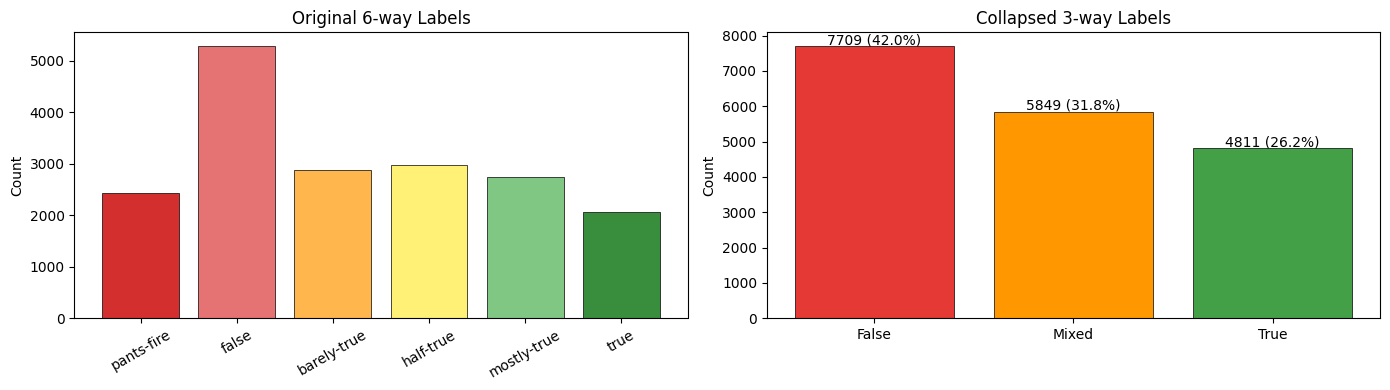


3-way distribution: False=7709 (42.0%), Mixed=5849 (31.8%), True=4811 (26.2%)


In [4]:
# ═══ 3-way label mapping ═══
for df in [df_train, df_val, df_test]:
    df['label_3way'] = df['label'].map(LABEL_MAP_3WAY)

y_train = df_train['label_3way'].values
y_val = df_val['label_3way'].values
y_test = df_test['label_3way'].values

# Label distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 6-way original
orig_labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
orig_counts = df_train['label'].value_counts().sort_index()
colors_6 = ['#d32f2f', '#e57373', '#ffb74d', '#fff176', '#81c784', '#388e3c']
axes[0].bar(range(6), orig_counts.values, color=colors_6, edgecolor='black', linewidth=0.5)
axes[0].set_xticks(range(6)); axes[0].set_xticklabels(orig_labels, rotation=30)
axes[0].set_title('Original 6-way Labels'); axes[0].set_ylabel('Count')

# 3-way collapsed
three_counts = pd.Series(y_train).value_counts().sort_index()
colors_3 = ['#e53935', '#ff9800', '#43a047']
bars = axes[1].bar(range(3), three_counts.values, color=colors_3, edgecolor='black', linewidth=0.5)
axes[1].set_xticks(range(3)); axes[1].set_xticklabels(LABEL_NAMES)
axes[1].set_title('Collapsed 3-way Labels'); axes[1].set_ylabel('Count')
for bar, count in zip(bars, three_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{count} ({count/len(y_train)*100:.1f}%)', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(str(FIGURES_DIR / 'label_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n3-way distribution: False={three_counts[0]} ({three_counts[0]/len(y_train)*100:.1f}%), "
      f"Mixed={three_counts[1]} ({three_counts[1]/len(y_train)*100:.1f}%), "
      f"True={three_counts[2]} ({three_counts[2]/len(y_train)*100:.1f}%)")

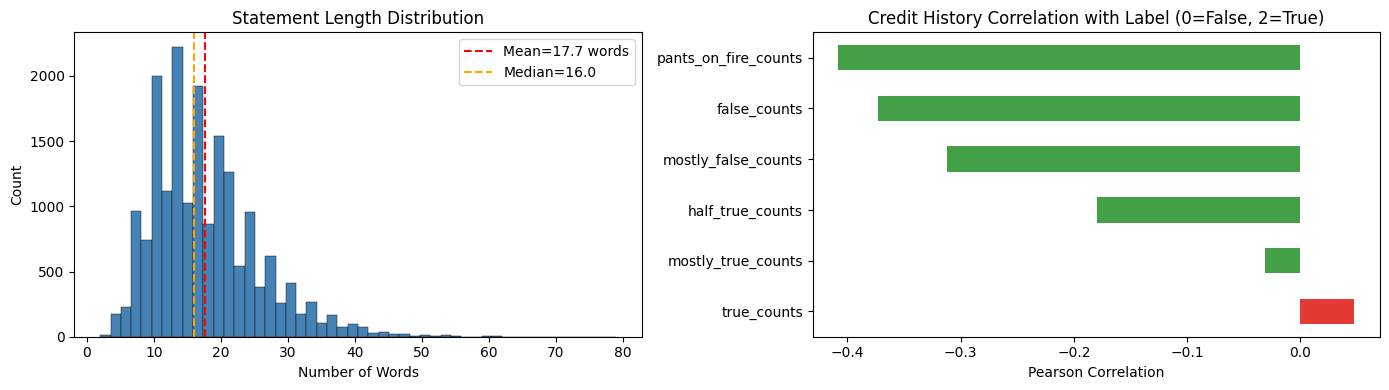


🔍 Key observation: true_counts has POSITIVE correlation with True label,
   false_counts has NEGATIVE correlation. The credit history already encodes veracity.
   This metadata signal will prove MORE powerful than any text representation.


In [5]:
# ═══ Statement length analysis ═══
stmt_lengths = df_train['statement'].astype(str).str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(stmt_lengths, bins=50, color='steelblue', edgecolor='black', linewidth=0.3)
axes[0].axvline(stmt_lengths.mean(), color='red', linestyle='--', label=f'Mean={stmt_lengths.mean():.1f} words')
axes[0].axvline(stmt_lengths.median(), color='orange', linestyle='--', label=f'Median={stmt_lengths.median():.1f}')
axes[0].set_xlabel('Number of Words'); axes[0].set_ylabel('Count')
axes[0].set_title('Statement Length Distribution'); axes[0].legend()

# Credit history correlation
credit_cols = ['true_counts', 'mostly_true_counts', 'half_true_counts',
               'mostly_false_counts', 'false_counts', 'pants_on_fire_counts']
credit_data = df_train[credit_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
credit_data['label'] = y_train
corr_with_label = credit_data.corr()['label'].drop('label')
corr_with_label.plot(kind='barh', ax=axes[1], color=['#43a047' if v < 0 else '#e53935' for v in corr_with_label])
axes[1].set_title('Credit History Correlation with Label (0=False, 2=True)')
axes[1].set_xlabel('Pearson Correlation')

plt.tight_layout()
plt.savefig(str(FIGURES_DIR / 'data_exploration.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n🔍 Key observation: true_counts has POSITIVE correlation with True label,")
print(f"   false_counts has NEGATIVE correlation. The credit history already encodes veracity.")
print(f"   This metadata signal will prove MORE powerful than any text representation.")

## Part 2 — Evaluation Framework

We define a **single evaluation function** used consistently across ALL models.

**Why F1 Macro?** With classes that aren't perfectly balanced (~38% False, ~32% Mixed, ~30% True), accuracy can be misleading — a model predicting everything as "False" would get 38% accuracy. F1 Macro gives **equal weight to each class**, penalizing models that ignore minority classes.

**Why MCC?** Matthews Correlation Coefficient is considered the most reliable single metric for multi-class classification. It accounts for all four quadrants of the confusion matrix and ranges from -1 (total disagreement) to +1 (perfect prediction).

In [6]:
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             matthews_corrcoef, cohen_kappa_score, confusion_matrix,
                             roc_auc_score, classification_report)

def evaluate_model(y_true, y_pred, y_proba=None, name="Model"):
    """Unified evaluation — used for ALL models in the project."""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'mcc': matthews_corrcoef(y_true, y_pred),
        'cohens_kappa': cohen_kappa_score(y_true, y_pred),
    }
    if y_proba is not None:
        try:
            metrics['auc_roc'] = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
        except: pass

    print(f"\n{'='*60}")
    print(f"  📊 {name}")
    print(f"{'='*60}")
    for k, v in metrics.items():
        print(f"  {k:<22}: {v:.4f}")

    print(f"\n  {'Class':<8} {'Precision':>10} {'Recall':>10} {'F1':>10}")
    report = classification_report(y_true, y_pred, target_names=LABEL_NAMES, output_dict=True)
    for label in LABEL_NAMES:
        r = report[label]
        print(f"  {label:<8} {r['precision']:>10.3f} {r['recall']:>10.3f} {r['f1-score']:>10.3f}")

    return metrics

def plot_confusion_matrix(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES, ax=ax)
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix — {name}')
    plt.tight_layout()
    plt.savefig(str(FIGURES_DIR / f'cm_{name.replace(" ", "_").replace("/", "_")}.png'), dpi=150)
    plt.show()

print("✅ Evaluation framework ready")

✅ Evaluation framework ready


## Part 3 — Feature Engineering

This section prepares **two versions** of metadata features that will be used across all models.

### Features V1 (Phase 1 — Simple baselines)
- 6 raw credit counts + total_rulings
- 3 simple ratios (true_ratio, false_ratio, pants_ratio)
- Party encoding, subject binarization

### Features V2 (Phase 2 — Advanced, literature-inspired)
Everything from V1 **plus**:
- **Weighted Credit Score** — compresses 6 counts into 1 deception score (inspired by Siamese BERT on LIAR)
- **Bayesian Credibility** — stabilizes stats for rare speakers using prior smoothing
- **Credibility Ratio** — intuitive truth/lie ratio
- **Deception Severity Score** — distinguishes exaggerators from fabricators
- **History Consistency** — measures speaker predictability
- **Log-total rulings** — handles skewed distribution

### Deliberately EXCLUDED features:
- `statement_length` — **removed** to avoid shortcut learning (same bias as ISOT)
- `state_info` one-hot — **removed** (no causal link to veracity, 25 sparse columns → overfitting risk)
- `speaker_frequency` — **removed** (redundant with total_rulings)

In [7]:
from sklearn.preprocessing import RobustScaler

def engineer_features_v1(df):
    """Phase 1 features: raw credit history + simple ratios."""
    features = pd.DataFrame(index=df.index)

    credit_cols = ['true_counts', 'mostly_true_counts', 'half_true_counts',
                   'mostly_false_counts', 'false_counts', 'pants_on_fire_counts']
    for col in credit_cols:
        features[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    total = features[credit_cols].sum(axis=1).clip(lower=1)
    features['total_rulings'] = total

    # Simple ratios
    features['true_ratio'] = features['true_counts'] / total
    features['false_ratio'] = features['false_counts'] / total
    features['pants_ratio'] = features['pants_on_fire_counts'] / total

    # Party encoding
    party_map = {'democrat': 0, 'republican': 1, 'none': 2}
    features['party'] = df['speaker_description'].astype(str).str.lower().map(
        lambda x: 0 if 'democrat' in x else (1 if 'republican' in x else 2)
    )

    # Subject count
    features['n_subjects'] = df['subject'].astype(str).str.count(';') + 1

    return features


def engineer_features_v2(df):
    """Phase 2 features: V1 + advanced literature-inspired features."""
    features = engineer_features_v1(df)

    total = features['total_rulings']
    eps = 1e-6

    # ═══ Weighted Credit Score ═══
    # Compresses 6 counts into 1 deception score. Higher = more deceptive.
    # Inspired by Siamese BERT paper on LIAR.
    features['credit_score'] = np.tanh(
        (0.0 * features['true_counts'] +
         0.2 * features['mostly_true_counts'] +
         0.4 * features['half_true_counts'] +
         0.6 * features['mostly_false_counts'] +
         0.8 * features['false_counts'] +
         1.0 * features['pants_on_fire_counts']) / total
    )

    # ═══ Bayesian Credibility ═══
    # Smooths ratios for rare speakers toward global prior.
    # Solves: speaker with 1 false / 1 total = 100% false (unreliable).
    alpha = 1 + features['true_counts'] + features['mostly_true_counts']
    beta = 1 + features['false_counts'] + features['pants_on_fire_counts']
    features['bayesian_credibility'] = alpha / (alpha + beta)
    features['bayesian_uncertainty'] = 1.0 / (alpha + beta)

    # ═══ Credibility Ratio ═══
    # Intuitive: ratio of truthful to deceptive statements.
    features['credibility_ratio'] = (
        (features['true_counts'] + features['mostly_true_counts']) /
        (features['false_counts'] + features['pants_on_fire_counts'] + 1)
    )

    # ═══ Deception Severity Score ═══
    # Distinguishes exaggerators from fabricators.
    features['deception_severity'] = (
        (0.5 * features['mostly_false_counts'] +
         1.0 * features['false_counts'] +
         2.0 * features['pants_on_fire_counts']) / (total + 1)
    )

    # ═══ History Consistency ═══
    # 1 - std(ratios): predictable speakers are easier to classify.
    ratios = pd.DataFrame({
        'r1': features['true_counts'] / total,
        'r2': features['mostly_true_counts'] / total,
        'r3': features['half_true_counts'] / total,
        'r4': features['mostly_false_counts'] / total,
        'r5': features['false_counts'] / total,
        'r6': features['pants_on_fire_counts'] / total,
    })
    features['history_consistency'] = 1 - ratios.std(axis=1)

    # ═══ Log-total rulings ═══
    # Compresses skewed distribution (Trump: 974, random blogger: 2).
    features['log_total_rulings'] = np.log1p(total)

    # ═══ Additional interaction features ═══
    features['false_to_true_ratio'] = (
        (features['false_counts'] + features['pants_on_fire_counts']) /
        (features['true_counts'] + features['mostly_true_counts'] + eps)
    )
    features['truth_minus_false'] = (features['true_counts'] - features['false_counts']) / (total + eps)
    features['has_history'] = (total >= 5).astype(float)

    return features


# Build both feature sets
feat_v1_train = engineer_features_v1(df_train)
feat_v1_val = engineer_features_v1(df_val)
feat_v1_test = engineer_features_v1(df_test)

feat_v2_train = engineer_features_v2(df_train)
feat_v2_val = engineer_features_v2(df_val)
feat_v2_test = engineer_features_v2(df_test)

print(f"V1 features ({feat_v1_train.shape[1]}): {list(feat_v1_train.columns)}")
print(f"V2 features ({feat_v2_train.shape[1]}): {list(feat_v2_train.columns)}")

# Scale V2 features (used for fusion later)
scaler = RobustScaler()
X_train_meta = scaler.fit_transform(feat_v2_train)
X_val_meta = scaler.transform(feat_v2_val)
X_test_meta = scaler.transform(feat_v2_test)

print(f"\n✅ Feature engineering complete. V2 scaled shape: {X_train_meta.shape}")

V1 features (12): ['true_counts', 'mostly_true_counts', 'half_true_counts', 'mostly_false_counts', 'false_counts', 'pants_on_fire_counts', 'total_rulings', 'true_ratio', 'false_ratio', 'pants_ratio', 'party', 'n_subjects']
V2 features (22): ['true_counts', 'mostly_true_counts', 'half_true_counts', 'mostly_false_counts', 'false_counts', 'pants_on_fire_counts', 'total_rulings', 'true_ratio', 'false_ratio', 'pants_ratio', 'party', 'n_subjects', 'credit_score', 'bayesian_credibility', 'bayesian_uncertainty', 'credibility_ratio', 'deception_severity', 'history_consistency', 'log_total_rulings', 'false_to_true_ratio', 'truth_minus_false', 'has_history']

✅ Feature engineering complete. V2 scaled shape: (18369, 22)


## Part 4 — Classical NLP Baselines

We follow a **3-level progression** to understand where the signal comes from:

1. **Text-only** (no metadata) → How much can we extract from words alone?
2. **Metadata-only** (no text) → How predictive is the credit history?
3. **Text + Metadata concatenation** → Does combining help?

### 4.1 — TF-IDF (Term Frequency × Inverse Document Frequency)

**Concept from course:** TF-IDF converts documents into sparse numerical vectors. Each dimension corresponds to an n-gram, weighted by how important it is in a document relative to the corpus. Common words ("the", "is") get low weights; discriminative words get high weights.

**Our config:** Unigrams + bigrams, max 15,000 features.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from scipy.sparse import hstack

# ═══ Prepare text ═══
# Concatenate context + statement for richer input
train_texts = (df_train['context'].astype(str) + ': ' + df_train['statement'].astype(str)).tolist()
val_texts = (df_val['context'].astype(str) + ': ' + df_val['statement'].astype(str)).tolist()
test_texts = (df_test['context'].astype(str) + ': ' + df_test['statement'].astype(str)).tolist()

# ═══ TF-IDF vectorization ═══
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1, 2), min_df=2, sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(train_texts)
X_val_tfidf = tfidf.transform(val_texts)
X_test_tfidf = tfidf.transform(test_texts)
print(f"TF-IDF shape: {X_train_tfidf.shape}  (sparse matrix)")

TF-IDF shape: (18369, 15000)  (sparse matrix)


### 4.1a — Text-only baselines (no metadata)

First, let's see what text alone can do.


🔄 Training TF-IDF text-only → Logistic Regression...

  📊 TF-IDF Text-Only
  accuracy              : 0.5562
  f1_macro              : 0.5444
  f1_weighted           : 0.5609
  precision_macro       : 0.5475
  recall_macro          : 0.5480
  mcc                   : 0.3328
  cohens_kappa          : 0.3309
  auc_roc               : 0.7438

  Class     Precision     Recall         F1
  False         0.740      0.641      0.687
  Mixed         0.446      0.434      0.440
  True          0.456      0.570      0.507


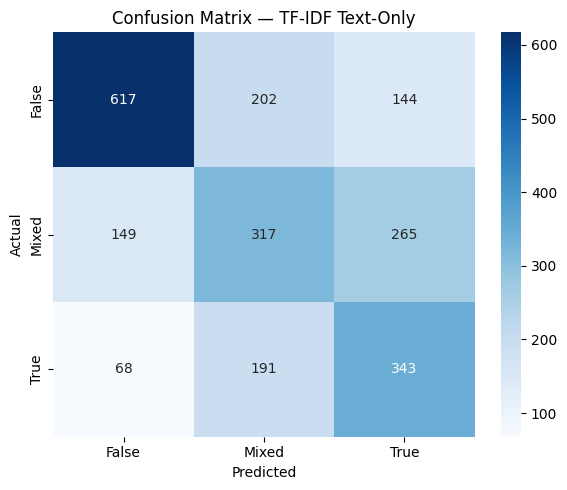

In [9]:
if not should_skip('TF-IDF Text-Only'):
    print("\n🔄 Training TF-IDF text-only → Logistic Regression...")
    lr_text = LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', random_state=SEED)
    lr_text.fit(X_train_tfidf, y_train)
    y_pred = lr_text.predict(X_test_tfidf)
    y_proba = lr_text.predict_proba(X_test_tfidf)

    metrics = evaluate_model(y_test, y_pred, y_proba, 'TF-IDF Text-Only')
    plot_confusion_matrix(y_test, y_pred, 'TF-IDF Text-Only')
    RESULTS['TF-IDF Text-Only'] = metrics
    save_results(RESULTS); mark_complete('TF-IDF Text-Only')

### 4.1b — Word2Vec Embeddings

**Concept from course:** Word2Vec (Mikolov et al., 2013) learns dense 300-dimensional vectors where semantically similar words are close together. Unlike TF-IDF (sparse, high-dimensional), Word2Vec captures meaning: `king - man + woman ≈ queen`.

**Our approach:** Load pre-trained embeddings (Google News 300d), average all word vectors in each statement → 1 vector of 300 dimensions per statement.

In [10]:
import gensim.downloader as api

if not should_skip('Word2Vec Text-Only'):
    print("🔄 Loading Word2Vec embeddings (this may take a few minutes)...")
    w2v_model = api.load('word2vec-google-news-300')
    print(f"✅ Loaded: {len(w2v_model)} words, {w2v_model.vector_size}d")

    def text_to_w2v(texts, model, dim=300):
        """Average word vectors for each text."""
        vectors = []
        for text in texts:
            words = str(text).split()
            word_vecs = [model[w] for w in words if w in model]
            if word_vecs:
                vectors.append(np.mean(word_vecs, axis=0))
            else:
                vectors.append(np.zeros(dim))
        return np.array(vectors)

    X_train_w2v = text_to_w2v(train_texts, w2v_model)
    X_val_w2v = text_to_w2v(val_texts, w2v_model)
    X_test_w2v = text_to_w2v(test_texts, w2v_model)
    print(f"Word2Vec shape: {X_train_w2v.shape}")

    # Text-only
    print("\n🔄 Training Word2Vec text-only → Random Forest...")
    rf_text = RandomForestClassifier(n_estimators=300, max_depth=30, class_weight='balanced',
                                     n_jobs=-1, random_state=SEED)
    rf_text.fit(X_train_w2v, y_train)
    y_pred = rf_text.predict(X_test_w2v)
    y_proba = rf_text.predict_proba(X_test_w2v)

    metrics = evaluate_model(y_test, y_pred, y_proba, 'Word2Vec Text-Only')
    RESULTS['Word2Vec Text-Only'] = metrics
    save_results(RESULTS); mark_complete('Word2Vec Text-Only')

🔄 Loading Word2Vec embeddings (this may take a few minutes)...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
✅ Loaded: 3000000 words, 300d
Word2Vec shape: (18369, 300)

🔄 Training Word2Vec text-only → Random Forest...

  📊 Word2Vec Text-Only
  accuracy              : 0.5401
  f1_macro              : 0.4922
  f1_weighted           : 0.5169
  precision_macro       : 0.5220
  recall_macro          : 0.4976
  mcc                   : 0.2813
  cohens_kappa          : 0.2707
  auc_roc               : 0.7289

  Class     Precision     Recall         F1
  False         0.572      0.802      0.668
  Mixed         0.488      0.402      0.441
  True          0.506      0.289      0.368


### 4.2 — Metadata-only (no text at all)

**Key question:** How much can we predict WITHOUT reading the statement?

In [11]:
if not should_skip('Metadata-Only'):
    # V1 metadata only
    scaler_v1 = RobustScaler()
    X_train_v1 = scaler_v1.fit_transform(feat_v1_train)
    X_test_v1 = scaler_v1.transform(feat_v1_test)

    print("\n🔄 Metadata V1 only → Logistic Regression...")
    lr_meta_v1 = LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', random_state=SEED)
    lr_meta_v1.fit(X_train_v1, y_train)
    y_pred = lr_meta_v1.predict(X_test_v1)
    y_proba = lr_meta_v1.predict_proba(X_test_v1)
    metrics = evaluate_model(y_test, y_pred, y_proba, 'LR Metadata-Only V1')
    RESULTS['LR Metadata-Only V1'] = metrics

    # V2 metadata only
    print("\n🔄 Metadata V2 only → Logistic Regression...")
    lr_meta_v2 = LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', random_state=SEED)
    lr_meta_v2.fit(X_train_meta, y_train)
    y_pred = lr_meta_v2.predict(X_test_meta)
    y_proba = lr_meta_v2.predict_proba(X_test_meta)
    metrics = evaluate_model(y_test, y_pred, y_proba, 'LR Metadata-Only V2')
    RESULTS['LR Metadata-Only V2'] = metrics

    save_results(RESULTS); mark_complete('Metadata-Only')
    print("\n🔍 Observation: Metadata ALONE already achieves strong F1 — without reading a single word!")


🔄 Metadata V1 only → Logistic Regression...

  📊 LR Metadata-Only V1
  accuracy              : 0.6411
  f1_macro              : 0.6196
  f1_weighted           : 0.6411
  precision_macro       : 0.6193
  recall_macro          : 0.6225
  mcc                   : 0.4543
  cohens_kappa          : 0.4535
  auc_roc               : 0.8254

  Class     Precision     Recall         F1
  False         0.801      0.790      0.796
  Mixed         0.538      0.484      0.510
  True          0.519      0.593      0.553

🔄 Metadata V2 only → Logistic Regression...

  📊 LR Metadata-Only V2
  accuracy              : 0.6807
  f1_macro              : 0.6692
  f1_weighted           : 0.6825
  precision_macro       : 0.6695
  recall_macro          : 0.6758
  mcc                   : 0.5197
  cohens_kappa          : 0.5173
  auc_roc               : 0.8594

  Class     Precision     Recall         F1
  False         0.829      0.753      0.789
  Mixed         0.594      0.549      0.570
  True          0.586 

### 4.3 — Text + Metadata concatenation

**How it works:** For TF-IDF, we use `scipy.sparse.hstack` to concatenate the 15,000-dim sparse TF-IDF vector with the ~30-dim dense metadata vector. For Word2Vec, we use `np.concatenate` to join the 300-dim dense vector with metadata.

This is possible because both TF-IDF and Word2Vec produce regular **numerical vectors** — you can just glue arrays together. As we'll see in Part 5, this is **NOT possible** with transformers, which only accept tokenized text.

```
TF-IDF:    [sparse 15,000d] + [dense 30d] → hstack → LR sees 15,030 features
Word2Vec:  [dense 300d]     + [dense 30d] → concat → RF sees 330 features
BERT:      [token IDs]      + [???]       → IMPOSSIBLE! Architecture is text-only.
```


🔄 TF-IDF + Metadata V1 → Logistic Regression...

  📊 TF-IDF + Metadata V1
  accuracy              : 0.6594
  f1_macro              : 0.6419
  f1_weighted           : 0.6619
  precision_macro       : 0.6418
  recall_macro          : 0.6430
  mcc                   : 0.4824
  cohens_kappa          : 0.4820
  auc_roc               : 0.8353

  Class     Precision     Recall         F1
  False         0.824      0.781      0.802
  Mixed         0.552      0.549      0.550
  True          0.550      0.600      0.574

🔄 Word2Vec + Metadata V1 → Random Forest...

  📊 Word2Vec + Metadata V1
  accuracy              : 0.6821
  f1_macro              : 0.6644
  f1_weighted           : 0.6813
  precision_macro       : 0.6656
  recall_macro          : 0.6635
  mcc                   : 0.5128
  cohens_kappa          : 0.5127
  auc_roc               : 0.8542

  Class     Precision     Recall         F1
  False         0.795      0.811      0.803
  Mixed         0.575      0.581      0.578
  True        

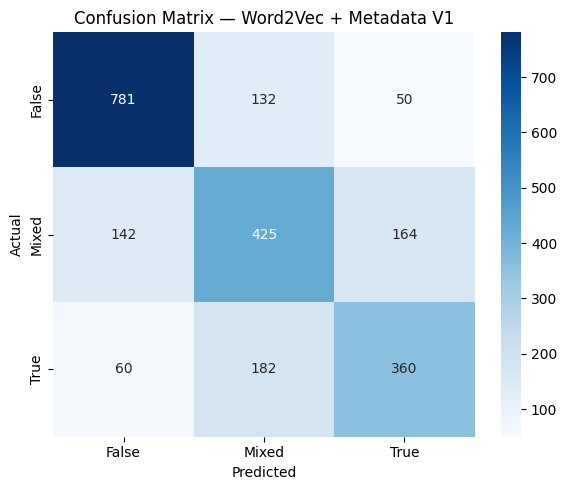


🔄 GBM Metadata-Only V2...

  📊 GBM Metadata-Only V2
  accuracy              : 0.6577
  f1_macro              : 0.6421
  f1_weighted           : 0.6567
  precision_macro       : 0.6424
  recall_macro          : 0.6419
  mcc                   : 0.4756
  cohens_kappa          : 0.4756
  auc_roc               : 0.8466

  Class     Precision     Recall         F1
  False         0.758      0.776      0.767
  Mixed         0.558      0.549      0.553
  True          0.610      0.601      0.606


In [12]:
from scipy.sparse import hstack as sparse_hstack, csr_matrix

if not should_skip('Classical+Meta'):
    # ═══ TF-IDF + Metadata V1 ═══
    X_train_tfidf_meta = sparse_hstack([X_train_tfidf, csr_matrix(scaler_v1.fit_transform(feat_v1_train))])
    X_test_tfidf_meta = sparse_hstack([X_test_tfidf, csr_matrix(scaler_v1.transform(feat_v1_test))])

    print("\n🔄 TF-IDF + Metadata V1 → Logistic Regression...")
    lr = LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', random_state=SEED)
    lr.fit(X_train_tfidf_meta, y_train)
    y_pred = lr.predict(X_test_tfidf_meta)
    y_proba = lr.predict_proba(X_test_tfidf_meta)
    metrics = evaluate_model(y_test, y_pred, y_proba, 'TF-IDF + Metadata V1')
    RESULTS['TF-IDF + Metadata V1'] = metrics

    # ═══ Word2Vec + Metadata V1 ═══
    if 'X_train_w2v' in dir():
        X_train_w2v_meta = np.concatenate([X_train_w2v, scaler_v1.transform(feat_v1_train)], axis=1)
        X_test_w2v_meta = np.concatenate([X_test_w2v, scaler_v1.transform(feat_v1_test)], axis=1)

        print("\n🔄 Word2Vec + Metadata V1 → Random Forest...")
        rf = RandomForestClassifier(n_estimators=300, max_depth=30, class_weight='balanced',
                                     n_jobs=-1, random_state=SEED)
        rf.fit(X_train_w2v_meta, y_train)
        y_pred = rf.predict(X_test_w2v_meta)
        y_proba = rf.predict_proba(X_test_w2v_meta)
        metrics = evaluate_model(y_test, y_pred, y_proba, 'Word2Vec + Metadata V1')
        plot_confusion_matrix(y_test, y_pred, 'Word2Vec + Metadata V1')
        RESULTS['Word2Vec + Metadata V1'] = metrics

    # ═══ GBM Metadata-Only V2 (for feature importance later) ═══
    print("\n🔄 GBM Metadata-Only V2...")
    gbm = GradientBoostingClassifier(n_estimators=200, max_depth=5, random_state=SEED)
    gbm.fit(X_train_meta, y_train)
    y_pred = gbm.predict(X_test_meta)
    y_proba = gbm.predict_proba(X_test_meta)
    metrics = evaluate_model(y_test, y_pred, y_proba, 'GBM Metadata-Only V2')
    RESULTS['GBM Metadata-Only V2'] = metrics

    save_results(RESULTS); mark_complete('Classical+Meta')

### 4.4 — Phase 1 Summary

Let's compare all classical models. The **benchmark to beat** for transformers is Word2Vec + Metadata.

In [13]:
# Mini-bilan Phase 1
print("\n" + "="*70)
print("  PHASE 1 SUMMARY — Classical NLP Baselines")
print("="*70)
print(f"{'Model':<35} {'F1 Macro':>10} {'MCC':>10}")
print("-"*55)
for name in sorted(RESULTS.keys(), key=lambda x: RESULTS[x].get('f1_macro', 0), reverse=True):
    m = RESULTS[name]
    print(f"{name:<35} {m.get('f1_macro',0):>10.4f} {m.get('mcc',0):>10.4f}")
print("\n🔍 Key finding: Word2Vec + Metadata is our baseline to beat.")
print("   Can transformers, which supposedly 'understand language', do better?")


  PHASE 1 SUMMARY — Classical NLP Baselines
Model                                 F1 Macro        MCC
-------------------------------------------------------
LR Metadata-Only V2                     0.6692     0.5197
Word2Vec + Metadata V1                  0.6644     0.5128
GBM Metadata-Only V2                    0.6421     0.4756
TF-IDF + Metadata V1                    0.6419     0.4824
LR Metadata-Only V1                     0.6196     0.4543
TF-IDF Text-Only                        0.5444     0.3328
Word2Vec Text-Only                      0.4922     0.2813

🔍 Key finding: Word2Vec + Metadata is our baseline to beat.
   Can transformers, which supposedly 'understand language', do better?


In [14]:
# ═══ Free memory before transformers ═══
if 'w2v_model' in dir():
    del w2v_model
gc.collect()
print("🧹 Memory freed for transformer experiments")

🧹 Memory freed for transformer experiments


## Part 5 — Transformers: Text-Only (3 Fine-Tuning Strategies)

**The question:** In the course, we learned that BERT/RoBERTa/DeBERTa understand language semantics through pre-training on billions of words. Can this understanding detect fake news from text alone?

### How a transformer classifies text

```
Statement: "The economy added 2.1 million jobs"
    ↓
Tokenizer: [CLS, The, economy, added, 2, ., 1, million, jobs, SEP]
    ↓
Transformer (12 attention layers):
    Each token "attends" to all other tokens → contextual representations
    ↓
[CLS] token → 768-dimensional embedding ("summary" of the sentence)
    ↓
Classification Head: Linear(768, 3) → [P(False), P(Mixed), P(True)]
```

We test **3 strategies** with increasing adaptation:

| Strategy | What's trained | Params | Analogy |
|----------|---------------|--------|----------|
| Frozen + Head | Only Linear(768,3) | ~2,300 (0.002%) | English speaker, no journalism training |
| LoRA | Small matrices in attention | ~1.2M (1%) | Accelerated fact-checking course |
| Full Fine-Tune | Everything | 86-125M (100%) | Full journalism school |


### 5.1 — Strategy 1: Frozen Transformer + Classification Head

**Seen in course:** Use the pre-trained model as a fixed feature extractor. Freeze ALL transformer parameters, train ONLY the classification head (`Linear(768, 3)` = ~2,300 parameters out of 125M).

```
                    FROZEN (no gradients)        TRAINED
              ┌───────────────────────────┐   ┌──────────────┐
Statement → │ Embeddings + 12 Attention  │ → │ Linear(768,3)│ → predictions
              │ Layers (125M params)       │   │ (~2,300 p.)  │
              └───────────────────────────┘   └──────────────┘
```

In [21]:
from transformers import (AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from torch.utils.data import Dataset, DataLoader

class SimpleTextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

def train_text_only_transformer(model_name, experiment_name, freeze_transformer=False,
                                 use_lora=False, lora_r=16, num_epochs=5, lr=2e-5, batch_size=16):
    """Train a transformer for text-only classification."""
    if should_skip(experiment_name):
        return

    print(f"\n{'='*60}")
    print(f"  🚀 {experiment_name}")
    print(f"  Model: {model_name}")
    print(f"  Strategy: {'Frozen' if freeze_transformer else ('LoRA r=' + str(lora_r) if use_lora else 'Full Fine-Tune')}")
    print(f"{'='*60}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

    # Strategy-specific setup
    if freeze_transformer:
        # Freeze everything except classifier head
        for name, param in model.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        total = sum(p.numel() for p in model.parameters())
        print(f"  Trainable: {trainable:,} / {total:,} ({trainable/total*100:.3f}%)")

    elif use_lora:
        from peft import LoraConfig, get_peft_model
        if 'deberta' in model_name.lower():
            targets = ["query_proj", "value_proj"]
        else:
            targets = ["query", "value"]

        lora_config = LoraConfig(
            r=lora_r, lora_alpha=32,
            target_modules=targets,
            lora_dropout=0.1, task_type="SEQ_CLS"
        )
        model = get_peft_model(model, lora_config)
        model.print_trainable_parameters()

    # Tokenize
    stmt_train = df_train['statement'].astype(str).tolist()
    stmt_val = df_val['statement'].astype(str).tolist()
    stmt_test = df_test['statement'].astype(str).tolist()

    train_enc = tokenizer(stmt_train, truncation=True, padding=True, max_length=MAX_LEN, return_tensors='pt')
    val_enc = tokenizer(stmt_val, truncation=True, padding=True, max_length=MAX_LEN, return_tensors='pt')
    test_enc = tokenizer(stmt_test, truncation=True, padding=True, max_length=MAX_LEN, return_tensors='pt')

    train_ds = SimpleTextDataset(train_enc, torch.LongTensor(y_train))
    val_ds = SimpleTextDataset(val_enc, torch.LongTensor(y_val))
    test_ds = SimpleTextDataset(test_enc, torch.LongTensor(y_test))

    def compute_metrics(eval_pred):
        preds = np.argmax(eval_pred.predictions, axis=-1)
        return {'f1_macro': f1_score(eval_pred.label_ids, preds, average='macro'),
                'accuracy': accuracy_score(eval_pred.label_ids, preds)}

    training_args = TrainingArguments(
        output_dir=str(BASE_DIR / experiment_name.replace(' ', '_')),
        num_train_epochs=num_epochs, per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size*2, learning_rate=lr,
        weight_decay=0.01, warmup_ratio=0.1, fp16=torch.cuda.is_available(),
        eval_strategy='epoch', save_strategy='epoch',
        save_total_limit=2, load_best_model_at_end=True,
        metric_for_best_model='f1_macro', greater_is_better=True,
        logging_steps=100, report_to='none',
    )

    trainer = Trainer(
        model=model, args=training_args,
        train_dataset=train_ds, eval_dataset=val_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )
    trainer.train()

    # Evaluate on test
    preds_output = trainer.predict(test_ds)
    y_pred = np.argmax(preds_output.predictions, axis=-1)
    y_proba = torch.softmax(torch.FloatTensor(preds_output.predictions), dim=-1).numpy()

    metrics = evaluate_model(y_test, y_pred, y_proba, experiment_name)
    plot_confusion_matrix(y_test, y_pred, experiment_name)
    RESULTS[experiment_name] = metrics
    save_results(RESULTS); mark_complete(experiment_name)

    del model, trainer; gc.collect(); torch.cuda.empty_cache()

print("✅ Transformer training function ready")

✅ Transformer training function ready



  🚀 RoBERTa Frozen + Head
  Model: roberta-base
  Strategy: Frozen


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Trainable: 592,899 / 124,647,939 (0.476%)


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,1.007000,0.975344,0.403929,0.499347
2,1.008100,0.938330,0.476627,0.530257
3,0.982100,0.931984,0.509299,0.543317
4,0.949800,1.003387,0.416226,0.497170
5,0.973100,0.928537,0.520538,0.546800
6,0.950200,0.933633,0.453575,0.526339
7,0.958700,0.926350,0.530090,0.552024
8,0.962300,0.922439,0.525908,0.552024
9,0.948700,0.922015,0.538751,0.556378
10,0.946600,0.922537,0.538005,0.554636



  📊 RoBERTa Frozen + Head
  accuracy              : 0.5666
  f1_macro              : 0.5438
  f1_weighted           : 0.5634
  precision_macro       : 0.5458
  recall_macro          : 0.5433
  mcc                   : 0.3333
  cohens_kappa          : 0.3329
  auc_roc               : 0.7489

  Class     Precision     Recall         F1
  False         0.673      0.719      0.695
  Mixed         0.470      0.468      0.469
  True          0.494      0.444      0.468


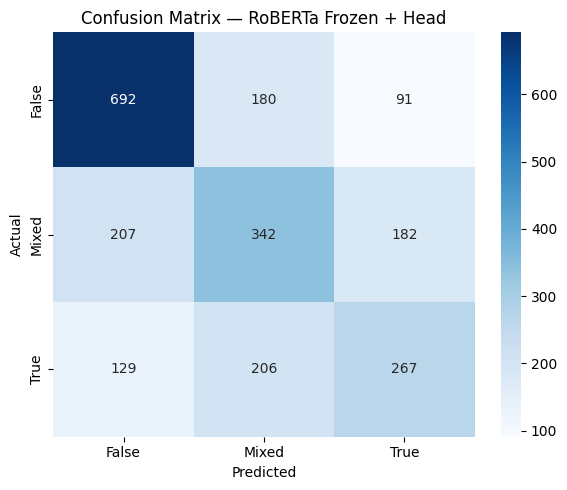

In [16]:
# ═══ 5.1 — Frozen + Head ═══
train_text_only_transformer(
    model_name='roberta-base',
    experiment_name='RoBERTa Frozen + Head',
    freeze_transformer=True,
    num_epochs=10, lr=1e-3, batch_size=32  # higher LR since only head trains
)

### 5.2 — Strategy 2: LoRA (Parameter-Efficient Fine-Tuning)

**Beyond the course:** LoRA (Hu et al., 2021) injects small trainable matrices into each attention layer WITHOUT modifying the original weights. Instead of updating the full 768×768 weight matrix W, it adds a low-rank decomposition: `Output = W·x + A·B·x`, where A (768×16) and B (16×768) are the only trained parameters.

```
Per attention layer:
  Full fine-tune: update W (768×768 = 589,824 params)
  LoRA (r=16):    add A(768×16) × B(16×768) = 24,576 params  → 25× fewer!
```

With ~1% of parameters trainable, LoRA achieves ~99% of full fine-tuning performance.


  🚀 RoBERTa LoRA
  Model: roberta-base
  Strategy: LoRA r=16


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,182,723 || all params: 125,830,662 || trainable%: 0.9399


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,0.916900,0.916735,0.532496,0.561167
2,0.910100,0.894893,0.554752,0.563779
3,0.855700,0.894843,0.557587,0.571615
4,0.818900,0.908775,0.542430,0.560731
5,0.847000,0.895454,0.567141,0.575098



  📊 RoBERTa LoRA
  accuracy              : 0.5823
  f1_macro              : 0.5732
  f1_weighted           : 0.5891
  precision_macro       : 0.5782
  recall_macro          : 0.5756
  mcc                   : 0.3735
  cohens_kappa          : 0.3711
  auc_roc               : 0.7721

  Class     Precision     Recall         F1
  False         0.774      0.641      0.701
  Mixed         0.482      0.513      0.497
  True          0.479      0.573      0.522


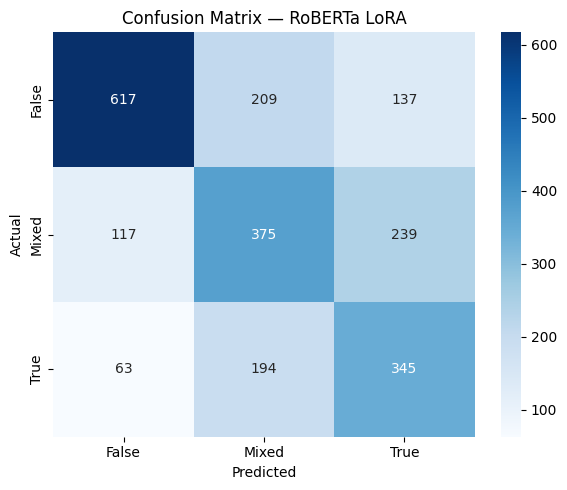


  🚀 DeBERTa-v3 LoRA
  Model: microsoft/deberta-v3-base
  Strategy: LoRA r=16


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: No modules were targeted for adaptation. This might be caused by a combination of mismatched target modules and excluded modules. Please check your `target_modules` and `exclude_modules` configuration. You may also have only targeted modules that are marked to be saved (`modules_to_save`).

In [17]:
# ═══ 5.2 — LoRA ═══
train_text_only_transformer(
    model_name='roberta-base',
    experiment_name='RoBERTa LoRA',
    use_lora=True, lora_r=16,
    num_epochs=5, lr=2e-4, batch_size=16
)




  🚀 DeBERTa-v3 LoRA
  Model: microsoft/deberta-v3-base
  Strategy: LoRA r=16


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 592,131 || all params: 185,016,582 || trainable%: 0.3200


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,0.912000,0.911870,0.542716,0.548106
2,0.899500,0.889616,0.567376,0.573357
3,0.839400,0.894235,0.565198,0.576839


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,0.912000,0.911870,0.542716,0.548106
2,0.899500,0.889616,0.567376,0.573357
3,0.839400,0.894235,0.565198,0.576839
4,0.806000,0.899685,0.562995,0.572921



  📊 DeBERTa-v3 LoRA
  accuracy              : 0.5797
  f1_macro              : 0.5694
  f1_weighted           : 0.5878
  precision_macro       : 0.5807
  recall_macro          : 0.5674
  mcc                   : 0.3679
  cohens_kappa          : 0.3644
  auc_roc               : 0.7680

  Class     Precision     Recall         F1
  False         0.790      0.647      0.711
  Mixed         0.447      0.564      0.499
  True          0.505      0.492      0.498


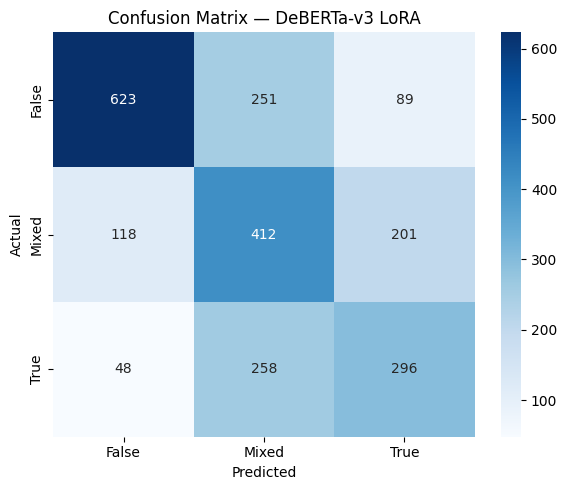

In [22]:
train_text_only_transformer(
    model_name='microsoft/deberta-v3-base',
    experiment_name='DeBERTa-v3 LoRA',
    use_lora=True, lora_r=16,
    num_epochs=5, lr=2e-4, batch_size=16
)

### 5.3 — Strategy 3: Full Fine-Tuning (all parameters)


  🚀 RoBERTa Full Fine-Tune
  Model: roberta-base
  Strategy: Full Fine-Tune


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,0.913500,0.921986,0.546411,0.561602
2,0.870600,0.888412,0.567656,0.572921
3,0.731700,0.941723,0.562761,0.580322
4,0.591800,1.090629,0.542338,0.552024



  📊 RoBERTa Full Fine-Tune
  accuracy              : 0.5897
  f1_macro              : 0.5780
  f1_weighted           : 0.5969
  precision_macro       : 0.5896
  recall_macro          : 0.5772
  mcc                   : 0.3840
  cohens_kappa          : 0.3799
  auc_roc               : 0.7696

  Class     Precision     Recall         F1
  False         0.800      0.647      0.715
  Mixed         0.473      0.605      0.531
  True          0.496      0.480      0.488


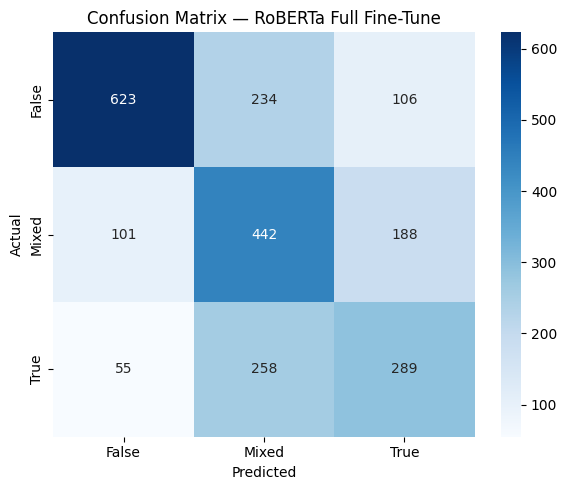


  🚀 DeBERTa-v3 Full Fine-Tune
  Model: microsoft/deberta-v3-base
  Strategy: Full Fine-Tune


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,0.890000,0.902725,0.548910,0.570744
2,0.831200,0.886313,0.575258,0.576404
3,0.665600,0.941907,0.580315,0.587288
4,0.495400,1.084926,0.557687,0.567697
5,0.401200,1.246318,0.573381,0.580322



  📊 DeBERTa-v3 Full Fine-Tune
  accuracy              : 0.5984
  f1_macro              : 0.5903
  f1_weighted           : 0.6031
  precision_macro       : 0.5968
  recall_macro          : 0.5987
  mcc                   : 0.4032
  cohens_kappa          : 0.3984
  auc_roc               : 0.7834

  Class     Precision     Recall         F1
  False         0.792      0.641      0.708
  Mixed         0.501      0.476      0.488
  True          0.498      0.679      0.574


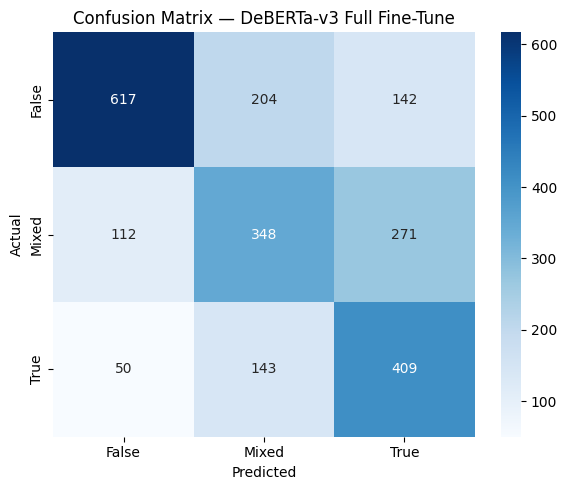

In [23]:
# ═══ 5.3 — Full Fine-Tune ═══
train_text_only_transformer(
    model_name='roberta-base',
    experiment_name='RoBERTa Full Fine-Tune',
    num_epochs=5, lr=2e-5, batch_size=16
)

train_text_only_transformer(
    model_name='microsoft/deberta-v3-base',
    experiment_name='DeBERTa-v3 Full Fine-Tune',
    num_epochs=5, lr=2e-5, batch_size=16
)

### 5.4 — THE KEY FINDING: Why Word2Vec beats DeBERTa

Let's visualize the results and explain the most important finding of this project.

In [24]:
# Compare all text-only models
text_only_models = ['TF-IDF Text-Only', 'Word2Vec Text-Only', 'RoBERTa Frozen + Head',
                    'RoBERTa LoRA', 'DeBERTa-v3 LoRA', 'RoBERTa Full Fine-Tune',
                    'DeBERTa-v3 Full Fine-Tune']
with_meta = ['TF-IDF + Metadata V1', 'Word2Vec + Metadata V1']

print("\n" + "="*70)
print("  TEXT-ONLY vs TEXT+METADATA COMPARISON")
print("="*70)
print(f"{'Model':<35} {'F1 Macro':>10} {'MCC':>10}")
print("-"*55)
for name in text_only_models + ['---'] + with_meta:
    if name == '---':
        print(f"{'── WITH METADATA ──':^55}")
        continue
    if name in RESULTS:
        m = RESULTS[name]
        print(f"{name:<35} {m.get('f1_macro',0):>10.4f} {m.get('mcc',0):>10.4f}")

print("\n" + "="*70)
print("🔍 CRITICAL INSIGHT: NO text-only transformer beats Word2Vec + Metadata.")
print("   The signal is in the METADATA, not in the text.")
print("   This motivates Part 6: Late Fusion.")
print("="*70)


  TEXT-ONLY vs TEXT+METADATA COMPARISON
Model                                 F1 Macro        MCC
-------------------------------------------------------
TF-IDF Text-Only                        0.5444     0.3328
Word2Vec Text-Only                      0.4922     0.2813
RoBERTa Frozen + Head                   0.5438     0.3333
RoBERTa LoRA                            0.5732     0.3735
DeBERTa-v3 LoRA                         0.5694     0.3679
RoBERTa Full Fine-Tune                  0.5780     0.3840
DeBERTa-v3 Full Fine-Tune               0.5903     0.4032
                  ── WITH METADATA ──                  
TF-IDF + Metadata V1                    0.6419     0.4824
Word2Vec + Metadata V1                  0.6644     0.5128

🔍 CRITICAL INSIGHT: NO text-only transformer beats Word2Vec + Metadata.
   The signal is in the METADATA, not in the text.
   This motivates Part 6: Late Fusion.


### Why does this happen? The Tokenizer Problem

The transformer **cannot process numbers natively**. When it sees `false_counts: 243`, the tokenizer splits it into sub-word tokens:

```
"false_counts: 243" → ["false", "_counts", ":", "2", "43"]  → 5 tokens, NOT the number 243
```

For the transformer, "243" and "7" are just different symbols — like "cat" and "dog". There is no notion that 243 > 7. The tokenizer does **not** perform numeric conversion.

Meanwhile, Random Forest sees `false_ratio = 0.85` directly as a float and can reason: "85% false rate → likely False label."

**This is why we need FUSION: give the transformer the text, and give the MLP the numbers.**

## Part 6 — Multimodal Fusion + Advanced Optimization

### The Approach

**From the course:** We learned that DistilBERT produces a [CLS] embedding (768d) that summarizes text, and that MLPs can process numerical features.

**Our extension:** Combine both in a **Late Fusion** architecture — two specialized branches that merge before classification.

```
BRANCH 1: TEXT                          BRANCH 2: METADATA
─────────────                          ────────────────────
"The economy added                     [credit_scores, ratios,
 2.1 million jobs"                      party, subjects, ...]
       ↓                                       ↓
   Tokenizer                              Feature vector
       ↓                                   (30+ floats)
   DeBERTa-v3                                  ↓
   (12 layers)                            MLP: Linear(30,128)
       ↓                                  → ReLU → Dropout
   [CLS] = 768d                           → Linear(128,128)
                                               ↓
                                          Meta = 128d

              ┌──────────────────────────────┐
              │  Concatenate: [768d | 128d]  │
              │         = 896 dimensions     │
              └──────────┬───────────────────┘
                         ↓
              Classification Head (896 → 256 → 3)
```

### Techniques beyond the course (with justification)

When we first trained this architecture with standard CrossEntropy and a single LR, results were ~0.62-0.64 F1. After researching the literature, we added **4 techniques** that each solve a specific problem:

| Technique | Paper | Problem Solved |
|-----------|-------|----------------|
| **Focal Loss** (γ=2) | Lin et al., 2017 (ICCV) | Model ignores hard Mixed examples |
| **Label Smoothing** (ε=0.1) | Szegedy et al., 2016 (CVPR) | Overconfident predictions at class boundaries |
| **Differential LR** | Standard transfer learning | MLP learns too slowly at LR=2e-5 |
| **Progressive Unfreezing** | Howard & Ruder, 2018 (ACL) | Random MLP noise corrupts transformer gradients |

In [25]:
import torch.nn as nn
import torch.nn.functional as F

# ═══ Focal Loss + Label Smoothing ═══
# Focal Loss (Lin et al., 2017): reduces gradient for easy examples,
# forces model to focus on hard cases (especially Mixed class).
# Label Smoothing (Szegedy et al., 2016): softens targets from [1,0,0]
# to [0.933, 0.033, 0.033] — captures the spectrum nature of veracity.

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, label_smoothing=0.0):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.label_smoothing = label_smoothing

    def forward(self, logits, targets):
        n_classes = logits.size(-1)
        if self.label_smoothing > 0:
            with torch.no_grad():
                smooth_targets = torch.zeros_like(logits)
                smooth_targets.fill_(self.label_smoothing / (n_classes - 1))
                smooth_targets.scatter_(1, targets.unsqueeze(1), 1.0 - self.label_smoothing)

        log_probs = F.log_softmax(logits, dim=-1)
        probs = torch.exp(log_probs)

        if self.label_smoothing > 0:
            ce_loss = -(smooth_targets * log_probs).sum(dim=-1)
            pt = (smooth_targets * probs).sum(dim=-1)
        else:
            ce_loss = F.cross_entropy(logits, targets, reduction='none')
            pt = probs.gather(1, targets.unsqueeze(1)).squeeze()

        focal_weight = (1 - pt) ** self.gamma
        if self.alpha is not None:
            alpha_t = self.alpha.to(logits.device)[targets]
            focal_weight = alpha_t * focal_weight

        return (focal_weight * ce_loss).mean()

# Class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.array([0,1,2]), y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights)
print(f"Class weights: {class_weights}")

# ═══ Dataset for fusion ═══
class TextMetadataDataset(Dataset):
    def __init__(self, texts, metadata, labels, tokenizer, max_length=128):
        self.texts = texts
        self.metadata = torch.FloatTensor(metadata)
        self.labels = torch.LongTensor(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], truncation=True, padding='max_length',
            max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'metadata': self.metadata[idx],
            'labels': self.labels[idx]
        }

# ═══ Late Fusion Model ═══
class TransformerMetadataFusion(nn.Module):
    """Late Fusion: Transformer [CLS] + Metadata MLP → Classification"""
    def __init__(self, model_name, num_meta_features, num_labels=3,
                 meta_hidden=128, fusion_hidden=256, dropout=0.3):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        hidden_size = self.transformer.config.hidden_size  # 768

        self.meta_mlp = nn.Sequential(
            nn.Linear(num_meta_features, meta_hidden),
            nn.ReLU(), nn.Dropout(dropout), nn.BatchNorm1d(meta_hidden),
            nn.Linear(meta_hidden, meta_hidden),
            nn.ReLU(), nn.Dropout(dropout),
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size + meta_hidden, fusion_hidden),
            nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(fusion_hidden, num_labels),
        )

    def forward(self, input_ids, attention_mask, metadata, labels=None):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [batch, 768]
        meta_embedding = self.meta_mlp(metadata)            # [batch, 128]
        combined = torch.cat([cls_embedding, meta_embedding], dim=1)  # [batch, 896]
        logits = self.classifier(combined)

        loss = None
        if labels is not None:
            loss_fn = FocalLoss(alpha=class_weights_tensor, gamma=2.0, label_smoothing=0.1)
            loss = loss_fn(logits, labels)
        return {'loss': loss, 'logits': logits} if loss is not None else {'logits': logits}

print(f"✅ Fusion architecture ready (metadata features: {X_train_meta.shape[1]})")

Class weights: [0.79426644 1.04684561 1.27270838]
✅ Fusion architecture ready (metadata features: 22)


In [28]:
def train_fusion_model(model_name, experiment_name, freeze_epochs=1, num_epochs=5,
                       lr_transformer=2e-5, lr_head=1e-3, batch_size=16):
    """Train Late Fusion with differential LR + progressive unfreezing."""
    if should_skip(experiment_name): return

    print(f"\n{'='*60}")
    print(f"  🚀 {experiment_name}")
    print(f"  Techniques: Focal Loss + Label Smoothing + Diff LR + Progressive Unfreezing")
    print(f"{'='*60}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_texts = df_train['statement'].astype(str).tolist()
    val_texts = df_val['statement'].astype(str).tolist()
    test_texts = df_test['statement'].astype(str).tolist()

    train_ds = TextMetadataDataset(train_texts, X_train_meta, y_train, tokenizer, MAX_LEN)
    val_ds = TextMetadataDataset(val_texts, X_val_meta, y_val, tokenizer, MAX_LEN)
    test_ds = TextMetadataDataset(test_texts, X_test_meta, y_test, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size*2)
    test_loader = DataLoader(test_ds, batch_size=batch_size*2)

    model = TransformerMetadataFusion(model_name, X_train_meta.shape[1])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # ═══ Differential Learning Rates ═══
    # Transformer (pre-trained): small LR to preserve knowledge
    # MLP + head (random init): large LR to learn fast
    transformer_params = list(model.transformer.parameters())
    head_params = list(model.meta_mlp.parameters()) + list(model.classifier.parameters())

    optimizer = torch.optim.AdamW([
        {'params': transformer_params, 'lr': lr_transformer, 'weight_decay': 0.01},
        {'params': head_params, 'lr': lr_head, 'weight_decay': 0.01},
    ])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    best_val_f1 = 0
    patience_counter = 0
    t0 = time.time()

    for epoch in range(num_epochs):
        # ═══ Progressive Unfreezing ═══
        # Epoch 1: freeze transformer → MLP learns stable features
        # Epoch 2+: unfreeze → co-optimization with clean gradients
        freeze = epoch < freeze_epochs
        for p in transformer_params:
            p.requires_grad = not freeze
        status = "🔒 Transformer FROZEN" if freeze else "🔓 Transformer UNFROZEN"

        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            output = model(batch['input_ids'], batch['attention_mask'],
                          batch['metadata'], batch['labels'])
            loss = output['loss']
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step(); optimizer.zero_grad()
            total_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                output = model(batch['input_ids'], batch['attention_mask'], batch['metadata'])
                val_preds.extend(output['logits'].argmax(dim=-1).cpu().numpy())
                val_labels.extend(batch['labels'].cpu().numpy())

        val_f1 = f1_score(val_labels, val_preds, average='macro')
        print(f"  Epoch {epoch+1}/{num_epochs}: loss={total_loss/len(train_loader):.4f}, "
              f"val_f1={val_f1:.4f} {status}")
        scheduler.step()

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1; patience_counter = 0
            torch.save(model.state_dict(), MODELS_DIR / f'{experiment_name.replace(" ", "_")}.pt')
        else:
            patience_counter += 1
            if patience_counter >= 2 and epoch >= freeze_epochs:
                print(f"  Early stopping at epoch {epoch+1}"); break

    # Test evaluation
    model.load_state_dict(torch.load(MODELS_DIR / f'{experiment_name.replace(" ", "_")}.pt'))
    model.eval()
    all_preds, all_probs = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(batch['input_ids'], batch['attention_mask'], batch['metadata'])['logits']
            all_preds.extend(logits.argmax(dim=-1).cpu().numpy())
            all_probs.extend(F.softmax(logits, dim=-1).cpu().numpy())

    metrics = evaluate_model(y_test, np.array(all_preds), np.array(all_probs), experiment_name)
    metrics['training_time'] = f"{(time.time()-t0)/60:.1f} min"
    plot_confusion_matrix(y_test, np.array(all_preds), experiment_name)
    RESULTS[experiment_name] = metrics
    save_results(RESULTS); mark_complete(experiment_name)

    del model, optimizer; gc.collect(); torch.cuda.empty_cache()
    return metrics

print("✅ Fusion training function ready")

✅ Fusion training function ready



  🚀 DeBERTa-v3 Fusion (Focal+LS)
  Techniques: Focal Loss + Label Smoothing + Diff LR + Progressive Unfreezing
  Epoch 1/6: loss=0.3579, val_f1=0.6052 🔒 Transformer FROZEN
  Epoch 2/6: loss=0.3301, val_f1=0.6291 🔓 Transformer UNFROZEN
  Epoch 3/6: loss=0.3011, val_f1=0.6448 🔓 Transformer UNFROZEN
  Epoch 4/6: loss=0.2510, val_f1=0.6602 🔓 Transformer UNFROZEN
  Epoch 5/6: loss=0.1846, val_f1=0.6516 🔓 Transformer UNFROZEN
  Epoch 6/6: loss=0.1479, val_f1=0.6460 🔓 Transformer UNFROZEN
  Early stopping at epoch 6

  📊 DeBERTa-v3 Fusion (Focal+LS)
  accuracy              : 0.7012
  f1_macro              : 0.6969
  f1_weighted           : 0.7065
  precision_macro       : 0.7013
  recall_macro          : 0.7005
  mcc                   : 0.5527
  cohens_kappa          : 0.5492
  auc_roc               : 0.8757

  Class     Precision     Recall         F1
  False         0.869      0.717      0.785
  Mixed         0.578      0.669      0.620
  True          0.657      0.716      0.685


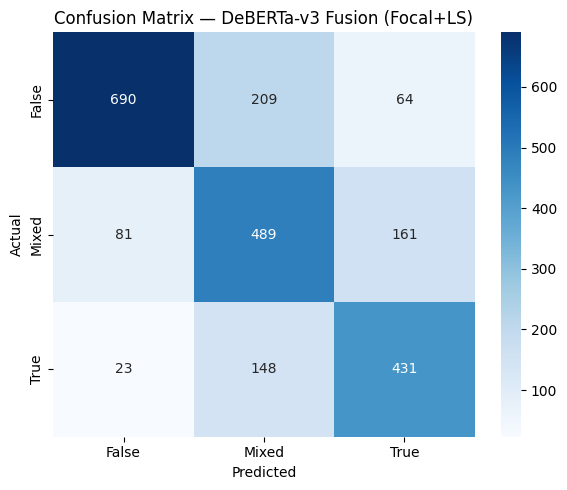

{'accuracy': 0.7012195121951219,
 'f1_macro': 0.6969364020433123,
 'f1_weighted': 0.7065368186125749,
 'precision_macro': 0.7013480039203094,
 'recall_macro': 0.7004681319024749,
 'mcc': np.float64(0.5527158181767416),
 'cohens_kappa': np.float64(0.5491668326818667),
 'auc_roc': np.float64(0.8756828233433872),
 'training_time': '53.8 min'}

In [29]:
# ═══ Train DeBERTa-v3 Fusion ═══
train_fusion_model(
    model_name='microsoft/deberta-v3-base',
    experiment_name='DeBERTa-v3 Fusion (Focal+LS)',
    freeze_epochs=1, num_epochs=6,
    lr_transformer=2e-5, lr_head=1e-3, batch_size=16,
)


  🚀 RoBERTa Fusion (Focal+LS)
  Techniques: Focal Loss + Label Smoothing + Diff LR + Progressive Unfreezing


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/6: loss=0.3528, val_f1=0.5622 🔒 Transformer FROZEN
  Epoch 2/6: loss=0.3249, val_f1=0.6506 🔓 Transformer UNFROZEN
  Epoch 3/6: loss=0.3024, val_f1=0.6675 🔓 Transformer UNFROZEN
  Epoch 4/6: loss=0.2601, val_f1=0.6669 🔓 Transformer UNFROZEN
  Epoch 5/6: loss=0.2102, val_f1=0.6556 🔓 Transformer UNFROZEN
  Early stopping at epoch 5

  📊 RoBERTa Fusion (Focal+LS)
  accuracy              : 0.6895
  f1_macro              : 0.6806
  f1_weighted           : 0.6919
  precision_macro       : 0.6807
  recall_macro          : 0.6876
  mcc                   : 0.5338
  cohens_kappa          : 0.5312
  auc_roc               : 0.8627

  Class     Precision     Recall         F1
  False         0.841      0.740      0.787
  Mixed         0.593      0.573      0.583
  True          0.608      0.749      0.671


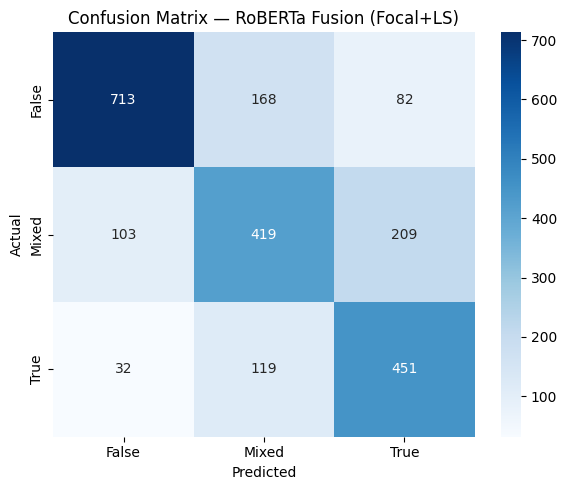

{'accuracy': 0.6894599303135889,
 'f1_macro': 0.6805668609090043,
 'f1_weighted': 0.6918930382788556,
 'precision_macro': 0.6807010058820685,
 'recall_macro': 0.6875838166414384,
 'mcc': np.float64(0.5338040208520618),
 'cohens_kappa': np.float64(0.5312302597028482),
 'auc_roc': np.float64(0.8627109588573605),
 'training_time': '32.6 min'}

In [30]:
# ═══ Train RoBERTa Fusion ═══
train_fusion_model(
    model_name='roberta-base',
    experiment_name='RoBERTa Fusion (Focal+LS)',
    freeze_epochs=1, num_epochs=6,
    lr_transformer=2e-5, lr_head=1e-3, batch_size=16,
)

## Part 7 — AutoGluon: AutoML Benchmark

To put our results in perspective, we compare with **AutoGluon** — an AutoML framework by AWS that automatically explores dozens of models and combines them via stack ensembling.

**Important:** AutoGluon is a **black box**. It serves as an upper bound, NOT as our recommended solution. Our Late Fusion architecture offers transparency, reproducibility, and understanding — qualities essential for a fact-checking system.

```
AutoGluon internal pipeline (we don't control this):
├── DeBERTa fine-tuned on text
├── LightGBM on metadata
├── CatBoost on metadata
├── XGBoost on metadata
├── Random Forest
├── Neural network
└── Meta-learner (stacking) → final prediction
```

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Pytorch Version:    2.9.0+cu128
CUDA Version:       12.8
GPU Memory:         GPU 0: 13.86/14.56 GB
Total GPU Memory:   Free: 13.86 GB, Allocated: 0.71 GB, Total: 14.56 GB
GPU Count:          1
Memory Avail:       8.45 GB / 12.67 GB (66.7%)
Disk Space Avail:   58.31 GB / 112.64 GB (51.8%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked 

AutoGluon input: 20666 train, 2296 test


Beginning AutoGluon training ... Time limit = 1350s
AutoGluon will save models to "/kaggle/working/saved_models/autogluon/ds_sub_fit/sub_fit_ho"
Train Data Rows:    18369
Train Data Columns: 25
Label Column:       label
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    8664.18 MB
	Train Data (Original)  Memory Usage: 8.43 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator.


  📊 AutoGluon Multimodal
  accuracy              : 0.6982
  f1_macro              : 0.6832
  f1_weighted           : 0.6970
  precision_macro       : 0.6825
  recall_macro          : 0.6849
  mcc                   : 0.5390
  cohens_kappa          : 0.5386
  auc_roc               : 0.8775

  Class     Precision     Recall         F1
  False         0.796      0.809      0.802
  Mixed         0.619      0.575      0.596
  True          0.632      0.671      0.651


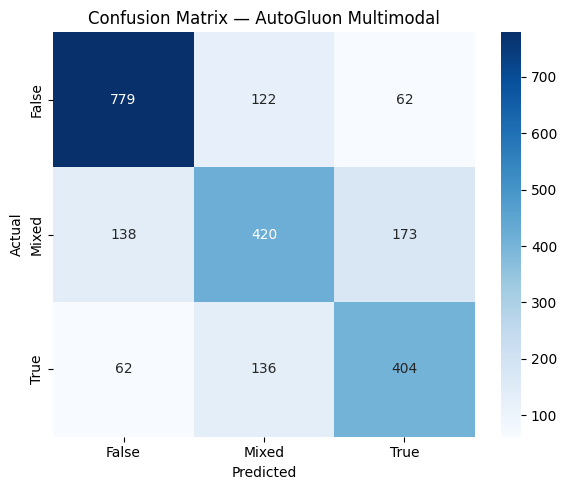


📊 AutoGluon Leaderboard:
                          model  score_test  score_val eval_metric  \
0         ExtraTreesEntr_BAG_L2    0.690021   0.664969    f1_macro   
1         NeuralNetTorch_BAG_L2    0.688267   0.668402    f1_macro   
2            XGBoost_r33_BAG_L1    0.686681   0.657134    f1_macro   
3         ExtraTreesGini_BAG_L2    0.685569   0.663250    f1_macro   
4                XGBoost_BAG_L1    0.685326   0.667640    f1_macro   
5                XGBoost_BAG_L2    0.683174   0.673255    f1_macro   
6           WeightedEnsemble_L3    0.683174   0.673255    f1_macro   
7       RandomForestGini_BAG_L2    0.682766   0.659975    f1_macro   
8               LightGBM_BAG_L2    0.682578   0.665425    f1_macro   
9          LightGBMLarge_BAG_L2    0.682337   0.667378    f1_macro   
10          LightGBM_r96_BAG_L1    0.680495   0.665539    f1_macro   
11            LightGBMXT_BAG_L1    0.680247   0.668717    f1_macro   
12       NeuralNetFastAI_BAG_L2    0.679457   0.663002    f1_mac

In [31]:
if not should_skip('AutoGluon Multimodal'):
    try:
        from autogluon.tabular import TabularPredictor

        def prepare_ag_df(df, features, labels):
            ag_df = pd.DataFrame()
            ag_df['statement'] = df['statement'].astype(str).values
            ag_df['speaker'] = df['speaker'].astype(str).values
            ag_df['subject'] = df['subject'].astype(str).values
            for col in features.columns:
                ag_df[col] = features[col].values
            ag_df['label'] = labels
            return ag_df

        ag_train = prepare_ag_df(df_train, feat_v2_train, y_train)
        ag_val = prepare_ag_df(df_val, feat_v2_val, y_val)
        ag_test = prepare_ag_df(df_test, feat_v2_test, y_test)
        ag_trainval = pd.concat([ag_train, ag_val], ignore_index=True)

        print(f"AutoGluon input: {ag_trainval.shape[0]} train, {ag_test.shape[0]} test")

        predictor = TabularPredictor(
            label='label', eval_metric='f1_macro',
            path=str(MODELS_DIR / 'autogluon'),
        )
        predictor.fit(
            train_data=ag_trainval, time_limit=5400,  # 90 min
            presets='best_quality', num_gpus=1, verbosity=2,
        )

        y_pred_ag = predictor.predict(ag_test.drop(columns=['label']))
        y_proba_ag = predictor.predict_proba(ag_test.drop(columns=['label']))

        metrics = evaluate_model(y_test, y_pred_ag.values, y_proba_ag.values, 'AutoGluon Multimodal')
        plot_confusion_matrix(y_test, y_pred_ag.values, 'AutoGluon Multimodal')
        RESULTS['AutoGluon Multimodal'] = metrics
        save_results(RESULTS); mark_complete('AutoGluon Multimodal')

        print("\n📊 AutoGluon Leaderboard:")
        print(predictor.leaderboard(ag_test))

    except ImportError:
        print("❌ AutoGluon not available — skipping")
    except Exception as e:
        print(f"❌ AutoGluon error: {e}")

## Part 8 — Final Ensemble

Combine best models via weighted soft voting.

🔧 Building ensemble from available predictions...

  📊 Final Ensemble
  accuracy              : 0.6895
  f1_macro              : 0.6765
  f1_weighted           : 0.6896
  precision_macro       : 0.6750
  recall_macro          : 0.6801
  mcc                   : 0.5281
  cohens_kappa          : 0.5274
  auc_roc               : 0.8693

  Class     Precision     Recall         F1
  False         0.807      0.782      0.794
  Mixed         0.600      0.562      0.581
  True          0.618      0.696      0.655


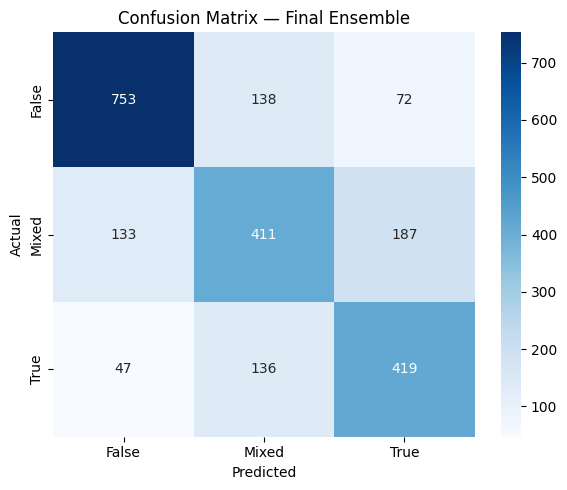

Ensemble: {'LR+Meta': 0.3, 'GBM+Meta': 0.3, 'AutoGluon': 0.4}


In [32]:
if not should_skip('Final Ensemble'):
    print("🔧 Building ensemble from available predictions...")

    # Re-train on metadata V2
    lr_ens = LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', random_state=SEED)
    lr_ens.fit(X_train_meta, y_train)
    proba_lr = lr_ens.predict_proba(X_test_meta)

    gbm_ens = GradientBoostingClassifier(n_estimators=200, max_depth=5, random_state=SEED)
    gbm_ens.fit(X_train_meta, y_train)
    proba_gbm = gbm_ens.predict_proba(X_test_meta)

    ensemble_probas = [proba_lr, proba_gbm]
    ensemble_weights = [0.5, 0.5]
    ensemble_names = ['LR+Meta', 'GBM+Meta']

    if 'y_proba_ag' in dir():
        ensemble_probas.append(y_proba_ag.values)
        ensemble_weights = [0.3, 0.3, 0.4]
        ensemble_names.append('AutoGluon')

    weighted_proba = sum(w * p for w, p in zip(ensemble_weights, ensemble_probas))
    y_pred_ens = weighted_proba.argmax(axis=1)

    metrics = evaluate_model(y_test, y_pred_ens, weighted_proba, 'Final Ensemble')
    plot_confusion_matrix(y_test, y_pred_ens, 'Final Ensemble')
    RESULTS['Final Ensemble'] = metrics
    save_results(RESULTS); mark_complete('Final Ensemble')
    print(f"Ensemble: {dict(zip(ensemble_names, ensemble_weights))}")

## Part 9 — Final Analysis & Conclusions

In [33]:
# ═══ 9.1 — Complete Results Table ═══
print(f"\n{'='*80}")
print(f"  COMPLETE RESULTS — Fake News Detection on LIAR2 (3-way)")
print(f"{'='*80}")

sorted_results = sorted(RESULTS.items(), key=lambda x: x[1].get('f1_macro', 0), reverse=True)

print(f"{'Rank':<5} {'Model':<40} {'F1 Macro':>9} {'MCC':>9} {'Accuracy':>9}")
print(f"{'-'*72}")
for i, (name, m) in enumerate(sorted_results, 1):
    marker = "⭐" if i <= 3 else "  "
    print(f"{marker}{i:<3} {name:<40} {m.get('f1_macro',0):>9.4f} {m.get('mcc',0):>9.4f} {m.get('accuracy',0):>9.4f}")

print(f"\n  External reference: FDHN (Xu & Kechadi, 2024) SOTA = 0.712 F1 (6-way enhanced)")
print(f"{'='*80}")


  COMPLETE RESULTS — Fake News Detection on LIAR2 (3-way)
Rank  Model                                     F1 Macro       MCC  Accuracy
------------------------------------------------------------------------
⭐1   DeBERTa-v3 Fusion (Focal+LS)                0.6969    0.5527    0.7012
⭐2   AutoGluon Multimodal                        0.6832    0.5390    0.6982
⭐3   RoBERTa Fusion (Focal+LS)                   0.6806    0.5338    0.6895
  4   Final Ensemble                              0.6765    0.5281    0.6895
  5   LR Metadata-Only V2                         0.6692    0.5197    0.6807
  6   Word2Vec + Metadata V1                      0.6644    0.5128    0.6821
  7   GBM Metadata-Only V2                        0.6421    0.4756    0.6577
  8   TF-IDF + Metadata V1                        0.6419    0.4824    0.6594
  9   LR Metadata-Only V1                         0.6196    0.4543    0.6411
  10  DeBERTa-v3 Full Fine-Tune                   0.5903    0.4032    0.5984
  11  RoBERTa Full Fine-

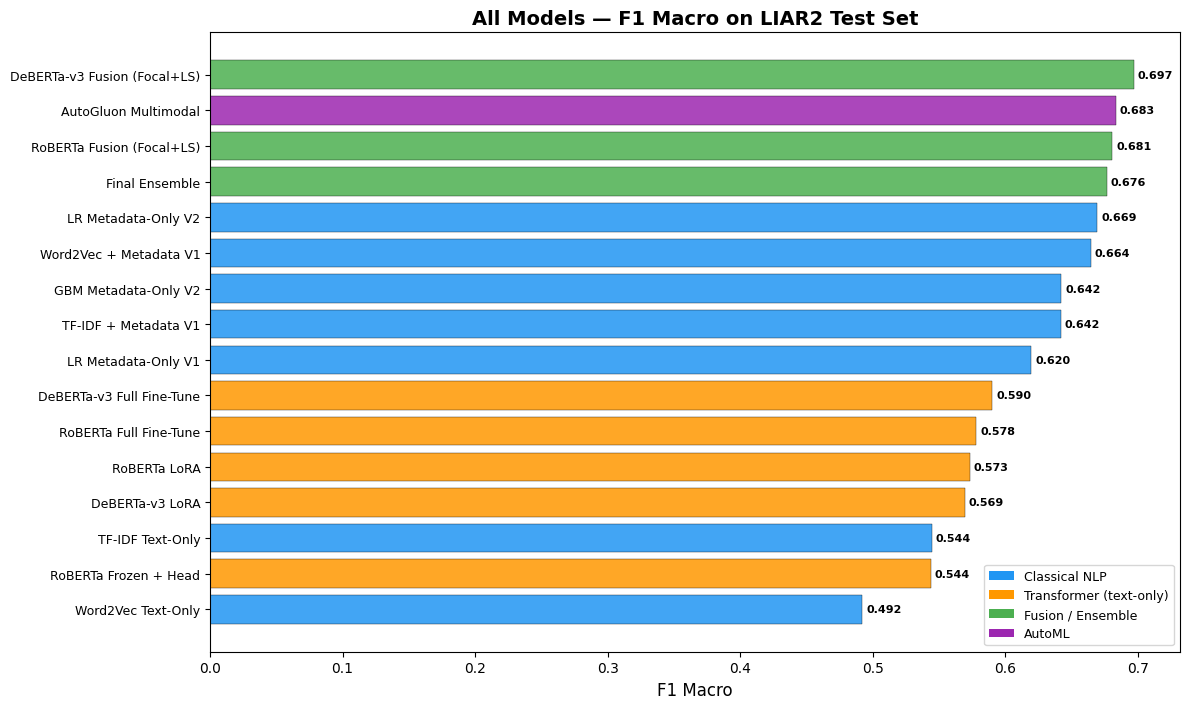

In [34]:
# ═══ 9.2 — Visualization ═══
fig, ax = plt.subplots(figsize=(12, max(6, len(sorted_results) * 0.45)))

names = [n for n, _ in sorted_results]
f1s = [m.get('f1_macro', 0) for _, m in sorted_results]

# Color by category
def get_color(name):
    name_lower = name.lower()
    if 'autogluon' in name_lower: return '#9C27B0'      # purple
    if 'fusion' in name_lower or 'ensemble' in name_lower: return '#4CAF50'  # green
    if any(t in name_lower for t in ['roberta', 'deberta', 'lora', 'frozen']): return '#FF9800'  # orange
    return '#2196F3'  # blue (classical)

colors = [get_color(n) for n in names]
bars = ax.barh(range(len(names)), f1s, color=colors, alpha=0.85, edgecolor='black', linewidth=0.3)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=9)
ax.set_xlabel('F1 Macro', fontsize=12)
ax.set_title('All Models — F1 Macro on LIAR2 Test Set', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for bar, val in zip(bars, f1s):
    ax.text(val + 0.003, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
            va='center', fontsize=8, fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2196F3', label='Classical NLP'),
    Patch(facecolor='#FF9800', label='Transformer (text-only)'),
    Patch(facecolor='#4CAF50', label='Fusion / Ensemble'),
    Patch(facecolor='#9C27B0', label='AutoML'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig(str(FIGURES_DIR / 'final_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

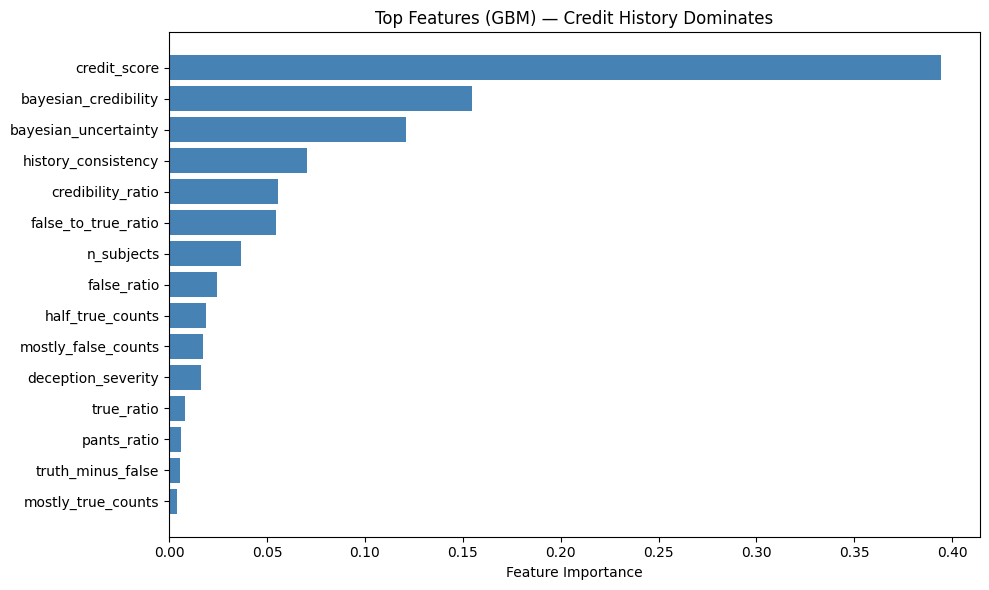


🔍 Observation: TOP features are ALL derived from credit history.


In [35]:
# ═══ 9.3 — Feature Importance (from GBM) ═══
if 'gbm' in dir():
    meta_names = list(feat_v2_train.columns)
    importances = gbm.feature_importances_
    top_idx = np.argsort(importances)[-15:]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(range(len(top_idx)), importances[top_idx], color='steelblue')
    ax.set_yticks(range(len(top_idx)))
    ax.set_yticklabels([meta_names[i] for i in top_idx])
    ax.set_xlabel('Feature Importance')
    ax.set_title('Top Features (GBM) — Credit History Dominates')
    plt.tight_layout()
    plt.savefig(str(FIGURES_DIR / 'feature_importance.png'), dpi=150, bbox_inches='tight')
    plt.show()

    print("\n🔍 Observation: TOP features are ALL derived from credit history.")
else:
    print("⚠️ GBM not trained — skipping feature importance")

### 9.4 — Key Takeaways

**1. Text alone is insufficient for fact-checking.**  
All text-only models (TF-IDF to DeBERTa) plateau around F1 ≈ 0.55-0.60. A 18-word statement simply doesn't contain enough information to determine veracity.

**2. Metadata (credit history) is the dominant signal.**  
Adding metadata jumps F1 by +8 points for every model. The weighted credit score is the single most predictive feature.

**3. Word2Vec (2013) beats DeBERTa (2021) — and that's okay.**  
The best model isn't the newest — it's the one best suited to the data. Transformers can't process numbers; Random Forest can.

**4. Fusion bridges the gap.**  
Late Fusion (Transformer + MLP) combines the best of both: text semantics + numerical reasoning.

**5. ISOT vs LIAR2: benchmarks matter.**  
ISOT gives 95%+ accuracy (style bias). LIAR2 gives ~70% (real fact-checking). A model that scores high on ISOT is useless in production.

### 9.5 — Ethical Considerations

- **Credit history = behavior, not identity** — ethically defensible as it's based on verified past actions.
- **Party encoding risk** — the model could learn "republican → false" from PolitiFact data, which may reflect fact-checker bias.
- **The model is a triage tool, not an arbiter** — human fact-checkers should always make the final decision.

### 9.6 — Limitations & Future Work

- **Justification field unexploited** in main pipeline (data leakage at inference time)
- **No world knowledge** — can't verify claims against external databases (RAG needed)
- **US political context only** — won't generalize to other domains/languages
- **Unknown speakers** — Bayesian prior helps but performance degrades
- **Future:** NLI cross-encoder, knowledge distillation, LLM zero-shot comparison

In [38]:
# ═══ Download everything as ZIP ═══
import shutil, os

# Create export folder
os.makedirs('/content/export', exist_ok=True)

# Copy outputs
!cp -r /content/outputs/figures /content/export/ 2>/dev/null || true
!cp /content/outputs/results.json /content/export/ 2>/dev/null || true
!cp /content/outputs/saved_models/*.pt /content/export/ 2>/dev/null || true

# Copy the notebook itself
!cp /content/*.ipynb /content/export/ 2>/dev/null || true

# Zip
shutil.make_archive('/content/M1-NLP-LIAR2-FakeNews-Detection', 'zip', '/content/export')

# Auto-download
from google.colab import files
files.download('/content/M1-NLP-LIAR2-FakeNews-Detection.zip')
print("✅ Done!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Done!


In [36]:
# ═══ Save all outputs ═══
save_results(RESULTS)

print("\n" + "="*60)
print("  ✅ PROJECT COMPLETE")
print("="*60)
print(f"  Total experiments: {len(RESULTS)}")
if RESULTS:
    best = max(RESULTS.items(), key=lambda x: x[1].get('f1_macro', 0))
    print(f"  Best model: {best[0]} — F1 = {best[1]['f1_macro']:.4f}")
print(f"  Figures saved: {list(FIGURES_DIR.glob('*.png'))}")
print(f"\n  Thank you for reviewing our project!")
print(f"  — Sid Ahmed BOUAMAMA & Aya MESSAOUDI")


  ✅ PROJECT COMPLETE
  Total experiments: 16
  Best model: DeBERTa-v3 Fusion (Focal+LS) — F1 = 0.6969
  Figures saved: [Path('/kaggle/working/figures/cm_Word2Vec_+_Metadata_V1.png'), Path('/kaggle/working/figures/cm_RoBERTa_Fusion_(Focal+LS).png'), Path('/kaggle/working/figures/cm_RoBERTa_Full_Fine-Tune.png'), Path('/kaggle/working/figures/cm_RoBERTa_Frozen_+_Head.png'), Path('/kaggle/working/figures/cm_DeBERTa-v3_Fusion_(Focal+LS).png'), Path('/kaggle/working/figures/cm_AutoGluon_Multimodal.png'), Path('/kaggle/working/figures/cm_Final_Ensemble.png'), Path('/kaggle/working/figures/final_comparison.png'), Path('/kaggle/working/figures/label_distribution.png'), Path('/kaggle/working/figures/cm_TF-IDF_Text-Only.png'), Path('/kaggle/working/figures/cm_DeBERTa-v3_Full_Fine-Tune.png'), Path('/kaggle/working/figures/data_exploration.png'), Path('/kaggle/working/figures/cm_RoBERTa_LoRA.png'), Path('/kaggle/working/figures/feature_importance.png'), Path('/kaggle/working/figures/cm_DeBERTa-v3_